In [1]:
from coagulation_model.coagulation_kernel import CoagulationKernel as kernel
from coagulation_model.sectional_mass_changes import SectionalMassChanges
from coagulation_model.sectional_coagulation_kernels import SectionalCoagulationKernels
from coagulation_model.particle_size_distribution import ParticleSizeDistribution as psd

from coagulation_model.plotting_kernels import plot_kernel_map
from coagulation_model.plotting_kernels import plot_normalized_kernel_map
from coagulation_model.plotting_kernels import plot_kernel_diff_map
from coagulation_model.plotting_kernels import plot_sectional_kernels
from coagulation_model.plotting_kernels import plot_particle_size_classes
from coagulation_model.plotting_kernels import plot_particle_size_distribution

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('notebook')

## Comparing sectional mass changes

In [2]:
# inistial sectional mass distribution from burds matlab code
matlab_particle_size_distribution = np.array([0.6283e-05, 0.0628e-05, 0.0063e-05, 0.0006e-05, 0.0001e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05])
# sectional mass changes at t=0 from burds matlab code
dvdt = np.array([-0.2244e-05, 0.0984e-05, 0.1037e-05, 0.0192e-05, 0.0027e-05, 0.0003e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05])

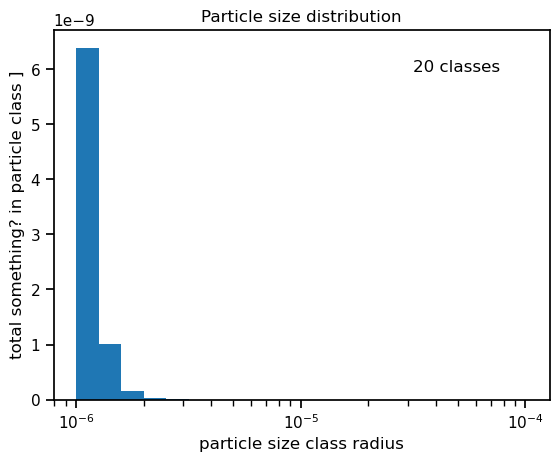

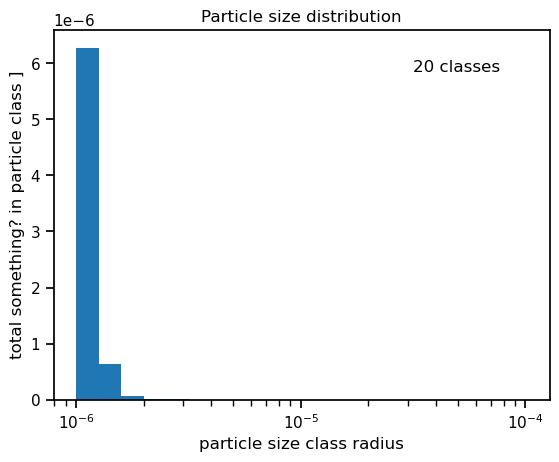

In [3]:
particle_size_distribution = psd(radius_sphere_min = 1e-6,radius_sphere_max = 1.1e-4,
                                 type='powerlaw',kwargs={'a':1.7e-56,'k':8})
fig1, ax1 = plot_particle_size_distribution(particle_size_distribution)


particle_size_distribution_matlab = psd(radius_sphere_min = 1e-6,radius_sphere_max = 1.1e-4,
                                 type='powerlaw',kwargs={'a':1.7e-56,'k':8})
particle_size_distribution_matlab.data = matlab_particle_size_distribution
fig2, ax2 = plot_particle_size_distribution(particle_size_distribution_matlab)


(<Figure size 1000x100 with 1 Axes>, <Axes: xlabel='particle radius [m]'>)

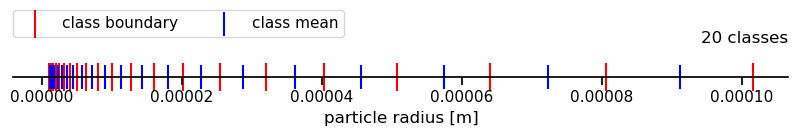

In [4]:
# volume of each size class 
volume_boundary_spheres = particle_size_distribution.radius_boundary_spheres**3
volume_mean_spheres = particle_size_distribution.radius_mean_spheres**3

# plot the volume on a number line
plot_particle_size_classes(particle_size_distribution.radius_boundary_spheres)



(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Radius of particle i (m)', ylabel='Radius of particle j (m)'>)

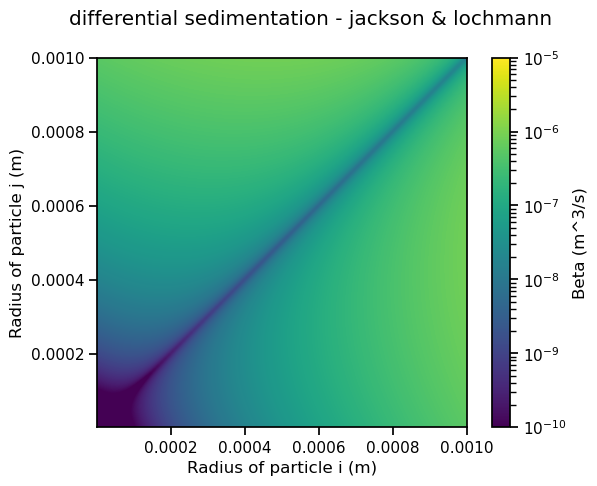

In [5]:
coagulation_kernel = kernel(
    list_of_applied_kernels=[
        # 'rectilinear_shear',
        'rectilinear_differential_sedimentation',
        ],
    settling_function='settling_velocity_jackson_lochmann_fractal'
    )

plot_kernel_map(coagulation_kernel, 'differential sedimentation - jackson & lochmann', norm_range = [1e-10, 1e-5], scale='lin')

In [6]:
jj = 0

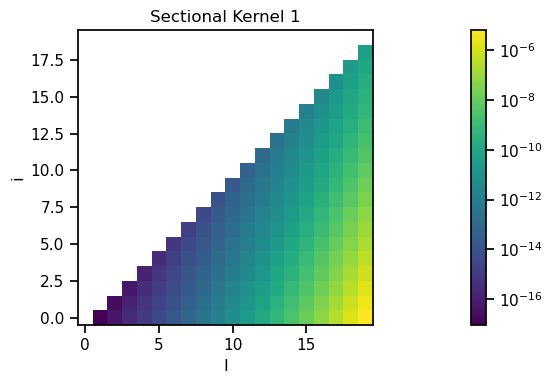

In [7]:
sectional_kernel = SectionalCoagulationKernels(coagulation_kernel,particle_size_distribution)
fig,ax = plot_sectional_kernels(np.array([sectional_kernel.data[jj]]))
fig,ax = plot_sectional_kernels(sectional_kernel.data)

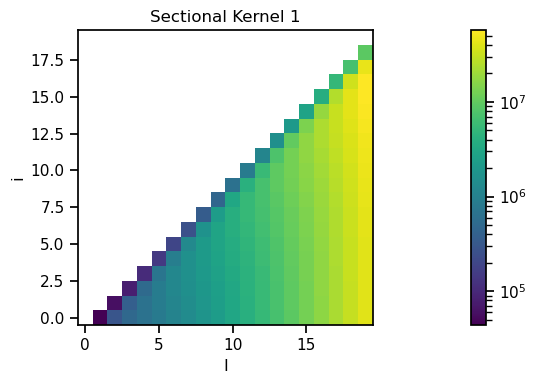

In [8]:
def read_beta_files(num_files, directory="coag_model_adrian_matlab"):
    """
    Read beta_i.txt files into a 3D numpy array.
    
    Args:
        num_files (int): Number of beta files to read (beta_1.txt to beta_n.txt)
        directory (str): Directory containing the beta files
        
    Returns:
        numpy.ndarray: 3D array of shape (num_files, 20, 20) containing all beta matrices
    """
    # Initialize 3D array to store all beta matrices
    beta_matrices = np.zeros((num_files, 20, 20))
    
    # Read each beta file
    for i in range(num_files):
        file_path = f"{directory}/beta_{i+1}.txt"
        try:
            beta_matrices[i] = np.loadtxt(file_path,delimiter=',')
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            
    return beta_matrices

matlab_betas = read_beta_files(5)

sectional_kernel_matlab = SectionalCoagulationKernels(coagulation_kernel,particle_size_distribution)
sectional_kernel_matlab.data = matlab_betas

# fig, ax = plot_sectional_kernels(np.array([sectional_kernel_matlab.data[jj]]))
fig, ax = plot_sectional_kernels(sectional_kernel_matlab.data)

In [10]:
matlab_betas[0,0,:]

array([       0.,    43686.,   288280.,   489520.,   658910.,   848190.,
        1084000.,  1390600.,  1796000.,  2336700.,  3060800.,  4032400.,
        5338000.,  7093600.,  9455300., 12633000., 16911000., 22669000.,
       30421000., 40857000.])

## Sectional mass changes

In [19]:
sectional_mass_changes = SectionalMassChanges(sectional_kernel,particle_size_distribution)
sectional_mass_changes.calc_coag_mass_changes_matmul()

# fig, ax = plot_sectional_kernels(sectional_mass_changes.components[:,:])

In [9]:
sectional_mass_changes_matlab = SectionalMassChanges(sectional_kernel_matlab,particle_size_distribution_matlab)
sectional_mass_changes_matlab.calc_coag_mass_changes_matmul()


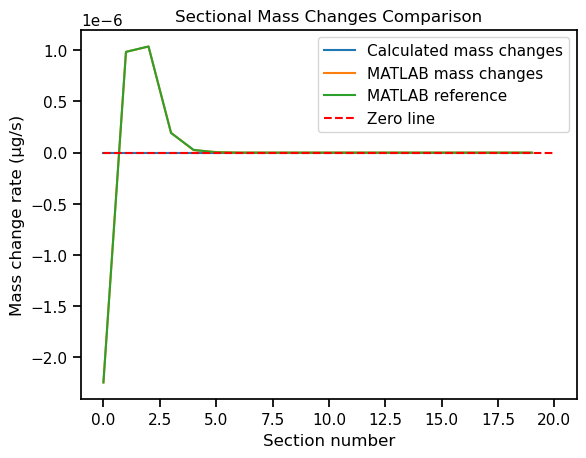

In [29]:
fig, ax = plt.subplots()
ax.plot(sectional_mass_changes.data, label='Calculated mass changes')
ax.plot(sectional_mass_changes_matlab.data*1, label='MATLAB mass changes')
ax.plot(dvdt, label='MATLAB reference')
ax.hlines(0, 0, 20, linestyles='dashed', colors='r', label='Zero line')

ax.set_xlabel('Section number')
ax.set_ylabel('Mass change rate (μg/s)')
ax.set_title('Sectional Mass Changes Comparison')
ax.legend()
plt.show()